In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from torch import nn
import torch
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

from data_prep import fetch_data, interpolate, set_target, backstep_columns, train_test_split
from model_utils import BasicData, train_net, pred_accuracy, LSTM

In [4]:
# Prep Data
df = fetch_data()
df = set_target(df, 1)
targets = df['target']
features = df.drop('target', axis=1)


# scaling
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

# shaping
backsteps = 10
shaped_features = backstep_columns(scaled_features, backsteps)
targets = targets[backsteps:]
assert shaped_features.shape[0] == targets.shape[0]

In [5]:
if torch.cuda.is_available():
    print("gpu available, using gpu")
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)  

gpu available, using gpu


In [6]:
model = LSTM(25, 10, 10, 1)
model.to(device)
accuracies = []
for i in range(300, len(shaped_features)-30, 30):
    X_train, X_test, y_train, y_test = train_test_split(
        shaped_features, targets,
        test_window=[i, i+30]
    )
    training_data = BasicData(X_train, y_train, device)
    test_data = BasicData(X_test, y_test, device)
    train_loader = DataLoader(
        training_data, batch_size=256, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        test_data, batch_size=256,
        shuffle=True, drop_last=True
    )
    # Train 50 epochs adding the new data in
    train_net(
        model, train_loader, test_data,
        loss_fn=torch.nn.BCEWithLogitsLoss(),
        epochs=50, learning_rate=0.01
    )
    month_acc = pred_accuracy(model(test_data.x).squeeze(), test_data.y)
    accuracies.append(month_acc)

In [8]:
import matplotlib.pyplot as plt

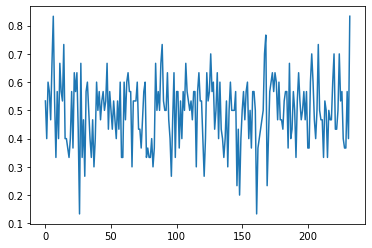

In [9]:
plt.plot(accuracies)

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

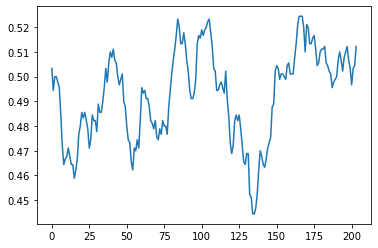

In [13]:
plt.plot(moving_average(accuracies, 30))

## Backtest un-augmented model

In [14]:
df = fetch_data(augment=False)
df = set_target(df, 1)
targets = df['target']
features = df.drop('target', axis=1)


# scaling
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)

# shaping
backsteps = 10
shaped_features = backstep_columns(scaled_features, backsteps)
targets = targets[backsteps:]
assert shaped_features.shape[0] == targets.shape[0]

In [15]:
shaped_features.shape

(7292, 11, 1)

In [16]:
model = LSTM(1, 5, 5, 1)
model.to(device)
accuracies = []
for i in range(300, len(shaped_features)-30, 30):
    X_train, X_test, y_train, y_test = train_test_split(
        shaped_features, targets,
        test_window=[i, i+30]
    )
    training_data = BasicData(X_train, y_train, device)
    test_data = BasicData(X_test, y_test, device)
    train_loader = DataLoader(
        training_data, batch_size=256, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        test_data, batch_size=256,
        shuffle=True, drop_last=True
    )
    # Train 50 epochs adding the new data in
    train_net(
        model, train_loader, test_data,
        loss_fn=torch.nn.BCEWithLogitsLoss(),
        epochs=50, learning_rate=0.01
    )
    month_acc = pred_accuracy(model(test_data.x).squeeze(), test_data.y)
    accuracies.append(month_acc)

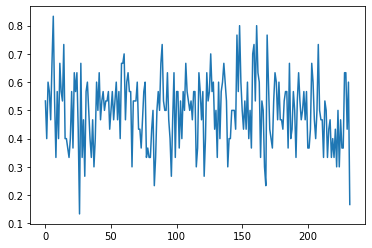

In [17]:
plt.plot(accuracies)

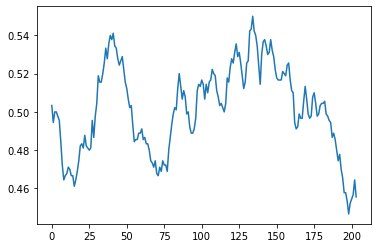

In [18]:
plt.plot(moving_average(accuracies, 30))